In [1]:
import argparse
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import random
from scipy.optimize import minimize
from scipy.stats import norm

BINS = 100

plt.rcParams['font.family'] = 'Times New Roman'
show_datasets = {
    'WIKI': 'Wikipedia',
    'REDDIT': 'REDDIT',
    'Flights': 'Flights',
    'LASTFM': 'LASTFM',
    'mooc': 'MOOC',
    'uci': 'UCI',
    'CollegeMsg': 'CollegeMsg'
}


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--data', type=str, default='', help='dataset name')
parser.add_argument('--high_freq', default=False, action='store_true')
parser.add_argument('--add_reverse', default=False, action='store_true')

args = parser.parse_args(['--data', 'mooc'])

print(args)

Namespace(data='mooc', high_freq=False, add_reverse=False)


In [3]:
def get_inter_activity_time(src):
    neighs, ts, eid  = ext_full_indices[src], ext_full_ts[src], ext_full_eid[src]
    intervals = []
    i = 0
    while i < len(neighs):
        ni = neighs[i]
        j = i
        while j < len(neighs)-1:
            nj = neighs[j]
            nk = neighs[j+1]
            if (ni == nj and ni != nk):
                intervals.append(ts[j] - ts[i])
                break
            elif j == len(neighs) - 2:
                intervals.append(ts[j+1] - ts[i])
                break
            else:
                j += 1
            
        i = j + 1
    return intervals

def get_activity_density(src):
    neighs, ts, eid  = ext_full_indices[src], ext_full_ts[src], ext_full_eid[src]
    intervals = []
    i = 0
    while i < len(neighs):
        ni = neighs[i]
        j = i
        l = 0
        while j < len(neighs)-1:
            nj = neighs[j]
            nk = neighs[j+1]
            if (ni == nj and ni != nk):
                intervals.append(j - i)
                break
            elif j == len(neighs) - 2:
                intervals.append(j + 1 - i)
                break
            else:
                j += 1
        i = j + 1
    return intervals
    
def tsort_original(i, indices, ts, eid):
    if not len(indices):
        return
    try:
        sidx = np.argsort(ts)
        indices = np.array(indices)[sidx]
        ts = np.array(ts)[sidx]
        eid = np.array(eid)[sidx]
    except TypeError:
        import pdb; pdb.set_trace()

# Bimodal distribution function
def bimodal(x, mu1, sigma1, mu2, sigma2, weight1):
    return weight1*norm.pdf(x, mu1, sigma1) + (1-weight1)*norm.pdf(x, mu2, sigma2)

# Constraint function
def tri_alpha_constraint(params):
    # Assuming params[0] = alpha1, params[1] = alpha2
    alpha1, alpha2 = params[-2], params[-1]
    return 1 - (alpha1 + alpha2)  # This needs to be >= 0

# Define the constraint dictionary
cons = ({'type': 'ineq', 'fun': tri_alpha_constraint})

# Bimodal distribution function
def trimodal(x, mu1, sigma1, mu2, sigma2, mu3, sigma3, weight1, weight2 ):
    return weight1*norm.pdf(x, mu1, sigma1) + weight2*norm.pdf(x, mu2, sigma2) + (1- weight1-weight2) *norm.pdf(x, mu3, sigma3)

# Objective function to minimize (Sum of Squared Differences)
def objective(params, bin_edges, counts):
    mu1, sigma1, mu2, sigma2, weight1 = params
    # Calculate the predicted counts for each bin
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    predicted_counts = bimodal(bin_centers, mu1, sigma1, mu2, sigma2, weight1) * sum(counts) * (bin_edges[1] - bin_edges[0])
    # Calculate SSD
    ssd = np.sum((counts - predicted_counts) ** 2)
    return ssd

# Objective function to minimize (Sum of Squared Differences)
def objective3(params, bin_edges, counts):
    mu1, sigma1, mu2, sigma2, mu3, sigma3, weight1, weight2 = params
    # Calculate the predicted counts for each bin
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    predicted_counts = trimodal(bin_centers, mu1, sigma1, mu2, sigma2, mu3, sigma3, weight1, weight2) * sum(counts) * (bin_edges[1] - bin_edges[0])
    # Calculate SSD
    ssd = np.sum((counts - predicted_counts) ** 2)
    return ssd

In [4]:
datasets = ['WIKI', 'REDDIT',]

dfs = []
all_data = {}
for i, data in enumerate(datasets):
    dfs.append(pd.read_csv('../DATA/{}/edges.csv'.format(data)))
    df = dfs[-1]
    s = 'src' if 'src' in df.columns else 'u'
    d = 'dst' if 'dst' in df.columns else 'i'
    t = 'time' if 'time' in df.columns else 'ts'
    num_nodes = max(int(df[s].max()), int(df[d].max())) + 1
    print('num_nodes: ', num_nodes)
    # import pdb; pdb.set_trace()
    ext_full_indptr = np.zeros(num_nodes + 1, dtype=np.int32)
    ext_full_indices = [[] for _ in range(num_nodes)]
    ext_full_ts = [[] for _ in range(num_nodes)]
    ext_full_eid = [[] for _ in range(num_nodes)]

    for idx, row in tqdm(df.iterrows(), total=len(df)):
        src = int(row[s])
        dst = int(row[d])
        
        ext_full_indices[src].append(dst)
        ext_full_ts[src].append(row[t])
        ext_full_eid[src].append(idx)
        
        if args.add_reverse:
            ext_full_indices[dst].append(src)
            ext_full_ts[dst].append(row[t])
            ext_full_eid[dst].append(idx)

    for i in tqdm(range(num_nodes)):
        ext_full_indptr[i + 1] = ext_full_indptr[i] + len(ext_full_indices[i])
    
    print('sorting and analyzing...')
    t_inter_act = []
    for i in tqdm(range(num_nodes)):
        tsort_original(i, ext_full_indices[i], ext_full_ts[i], ext_full_eid[i])
        t_inter_act += get_inter_activity_time(i)

    t_inter_act = np.array(t_inter_act)

    all_data[data] = {
        'indptr': ext_full_indptr,
        'indices': ext_full_indices,
        'ts': ext_full_ts,
        'eid': ext_full_eid,
        't_inter': t_inter_act,
    }

num_nodes:  9228


100%|██████████| 9228/9228 [00:00<00:00, 1118545.71it/s]


sorting and analyzing...


100%|██████████| 9228/9228 [00:00<00:00, 143433.80it/s]


num_nodes:  10985


100%|██████████| 10985/10985 [00:00<00:00, 1106707.09it/s]


sorting and analyzing...


100%|██████████| 10985/10985 [00:00<00:00, 52141.92it/s]


num_nodes:  13170


100%|██████████| 13170/13170 [00:00<00:00, 1099611.50it/s]


sorting and analyzing...


100%|██████████| 13170/13170 [00:00<00:00, 22456.82it/s]


num_nodes:  1980


100%|██████████| 1980/1980 [00:00<00:00, 1053764.99it/s]


sorting and analyzing...


100%|██████████| 1980/1980 [00:00<00:00, 4342.44it/s]


num_nodes:  1900


100%|██████████| 1900/1900 [00:00<00:00, 1019989.45it/s]


sorting and analyzing...


100%|██████████| 1900/1900 [00:00<00:00, 70508.72it/s]


WIKI
REDDIT


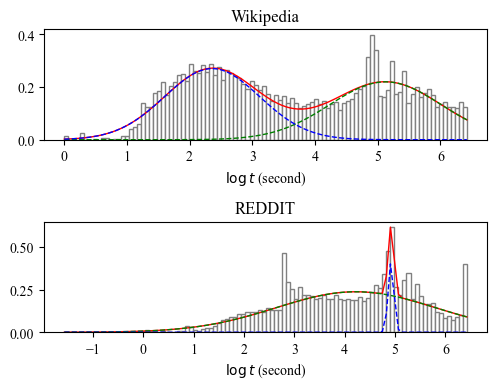

In [13]:
# row=len(['WIKI', 'uci', 'REDDIT', 'Flights', ])
row=len(['WIKI', 'REDDIT', ])
datasets = ['WIKI', 'REDDIT']
fig, axes = plt.subplots(row, len(datasets)//row, figsize=(5, 4))
for i, data in enumerate(datasets):
    print(data)
    ax = axes.flat[i]
    df = dfs[i]
    
    ext_full_indptr, ext_full_indices, ext_full_ts, ext_full_eid, t_inter_act = all_data[data]['indptr'],\
    all_data[data]['indices'], all_data[data]['ts'], all_data[data]['eid'], all_data[data]['t_inter']
    
    p1 = np.percentile(t_inter_act, 0.01)
    p99 = np.percentile(t_inter_act, 99.99)

    filtered_data = t_inter_act[(t_inter_act > p1) & (t_inter_act < p99)]
    x = pd.Series(filtered_data)

    x_log = np.log10(x)
    hist, bins = np.histogram(x_log, BINS, density=True)

    if not args.high_freq:
        initial_params = [2, 0.1, 5, 0.1, 0.5]
        result = minimize(objective, initial_params, args=(bins, hist), bounds=[(0, 10), (0.01, 1e3), (0, 10), (0.01, 1e3), (0.2, 1)])
        mu1, sigma1, mu2, sigma2, weight1 = result.x
        normal1_pdf = norm.pdf(bins, mu1, sigma1) * weight1
        normal2_pdf = norm.pdf(bins, mu2, sigma2) * (1 - weight1)
        bimodal_pdf = bimodal(bins, mu1, sigma1, mu2, sigma2, weight1)
        ax.plot(bins, bimodal_pdf, label='Fitted bimodal distribution', color='red', linewidth=1)
        ax.plot(bins, normal1_pdf, label='Normal distribution 1', color='green', linestyle='--', linewidth=1)
        ax.plot(bins, normal2_pdf, label='Normal distribution 2', color='blue', linestyle='--', linewidth=1)
    else:
        initial_params = [0, 0.1, 1, 0.1, 5, 0.1, 0.33, 0.33]
        result = minimize(objective3, initial_params, args=(bins, hist), 
                        bounds=[(0, 10), (0.01, 1e3),(0, 10), (0.01, 1e3), (0, 10), (0.01, 1e3), (0.2, 1), (0.2, 1)],
                        constraints=cons)
        mu1, sigma1, mu2, sigma2, mu3, sigma3, weight1, weight2 = result.x
        weight3 = 1 - weight1 - weight2
        normal1_pdf = norm.pdf(bins, mu1, sigma1) * weight1
        normal2_pdf = norm.pdf(bins, mu2, sigma2) * weight2
        normal3_pdf = norm.pdf(bins, mu3, sigma3) * weight3
        trimodal_pdf = trimodal(bins, mu1, sigma1, mu2, sigma2, mu3, sigma3, weight1, weight2)
        ax.plot(bins, trimodal_pdf, label='Fitted bimodal distribution', color='red', linewidth=1)
        ax.plot(bins, normal1_pdf, label='Normal distribution 1', color='green', linestyle='--', linewidth=1)
        ax.plot(bins, normal2_pdf, label='Normal distribution 2', color='blue', linestyle='--', linewidth=1)
        ax.plot(bins, normal3_pdf, label='Normal distribution 3', color='grey', linestyle='--', linewidth=1)
    ax.hist(x_log, BINS, density=True, stacked=True, color='white', edgecolor=(0.5, 0.5, 0.5))
    if data == 'Flights':
        ax.set_xlabel(f'$\log t$ (day)')
    else:
        ax.set_xlabel(f'$\log t $ (second)')
    ax.set_title(f'{show_datasets[data]}')
plt.tight_layout()
plt.savefig(f'../figures/session/all_sessions.pdf',bbox_inches='tight')

In [6]:



plt.xlabel(xlabel)
plt.legend()
plt.suptitle(f'{args.data} session length distribution')
plt.tight_layout()
if args.high_freq:
    plt.savefig(f'figures/session/{args.data}_session_3.pdf')
else:
    plt.savefig(f'figures/session/{args.data}_session.pdf')


NameError: name 'xlabel' is not defined